# Predicción de Cancelación de Clientes — Interconnect

Este proyecto tiene como objetivo desarrollar un modelo de machine learning que prediga la **tasa de cancelación de clientes (churn)** para la empresa de telecomunicaciones **Interconnect**. El modelo permitirá a la empresa identificar clientes en riesgo de cancelar el servicio, para ofrecerles promociones u opciones personalizadas a tiempo.

## Importación de Librerías y Tablas

In [1]:
# Importación de librerías 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier, Pool 
from lightgbm import LGBMClassifier

import shap 

c:\Users\lloyd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carga de datos 
contract = pd.read_csv('final_provider/contract.csv')
contract.name = 'contract'
internet = pd.read_csv('final_provider/internet.csv')
internet.name = 'internet'
personal = pd.read_csv('final_provider/personal.csv')
personal.name = 'personal'
phone = pd.read_csv('final_provider/phone.csv')
phone.name = 'phone'

In [3]:
# Revisar tamaño de las tablas 
dfs = [contract, internet, personal, phone]

for df in dfs: 
    print(f'DF: {df.name}')
    print(f'{df.shape[0]} filas, {df.shape[1]} columnas')

DF: contract
7043 filas, 8 columnas
DF: internet
5517 filas, 8 columnas
DF: personal
7043 filas, 5 columnas
DF: phone
6361 filas, 2 columnas


In [4]:
contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4200,8316-BBQAY,2014-09-01,No,Two year,No,Credit card (automatic),59.95,3921.1
5970,4853-OITSN,2019-09-01,No,Month-to-month,Yes,Electronic check,89.15,413.25
5316,1470-PSXNM,2016-01-01,No,One year,Yes,Electronic check,93.65,4520.15
5357,1460-UZPRJ,2015-02-01,No,Two year,No,Mailed check,19.95,1258.15
6651,2038-YSEZE,2017-09-01,No,Month-to-month,No,Mailed check,67.45,1801.1
6902,5820-PTRYM,2015-06-01,No,One year,Yes,Credit card (automatic),68.45,4014
3291,9143-CANJF,2018-02-01,No,Month-to-month,No,Electronic check,55.15,1319.85
222,6469-MRVET,2020-01-01,No,One year,Yes,Electronic check,20.20,20.2
6392,3999-WRNGR,2015-02-01,No,Month-to-month,Yes,Electronic check,49.75,3069.45
531,1403-GYAFU,2014-04-01,No,Two year,No,Credit card (automatic),20.05,1360.25


In [5]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5453,7240-FQLHE,Fiber optic,No,No,No,Yes,Yes,Yes
1535,0019-EFAEP,Fiber optic,Yes,Yes,Yes,No,Yes,No
779,5002-GCQFH,Fiber optic,Yes,Yes,No,No,Yes,No
45,9420-LOJKX,Fiber optic,Yes,Yes,No,No,Yes,Yes
2431,4429-WYGFR,DSL,No,No,No,Yes,No,No
1747,8378-LKJAF,Fiber optic,No,No,Yes,No,Yes,Yes
3061,3115-JPJDD,Fiber optic,Yes,No,Yes,No,No,No
3189,2688-BHGOG,Fiber optic,No,No,No,No,No,Yes
1791,3571-RFHAR,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
2722,2828-SLQPF,DSL,No,No,No,No,No,No


In [6]:
personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
4296,4489-SNOJF,Female,0,Yes,Yes
1009,6419-ZTTLE,Male,1,Yes,No
1576,0993-OSGPT,Female,1,Yes,No
2025,1488-PBLJN,Female,0,Yes,Yes
5989,5567-WSELE,Male,1,Yes,No
1809,9606-PBKBQ,Male,1,Yes,No
4125,2716-GFZOR,Male,0,Yes,No
3666,3194-ORPIK,Female,0,Yes,Yes
6348,1025-FALIX,Female,0,No,No
2581,0380-ZCSBI,Male,0,No,No


In [7]:
phone.sample(10)

,customerID,MultipleLines
5956,6340-DACFT,No
3454,7868-BGSZA,Yes
6118,7672-VFMXZ,No
6320,4174-LPGTI,No
4347,9814-AOUDH,No
4711,7096-ZNBZI,Yes
5083,9152-AMKAK,No
2955,7711-YIJWC,No
2050,1013-QCWAM,Yes
5034,8746-BFOAJ,No


## Limpieza de Datos

In [8]:
# Función para renombrar columnas a snake_case
def to_snake_case(name): 
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    return name.lower()

In [9]:
for df in dfs: 
    df.columns = [to_snake_case(col) for col in df.columns]
    

In [10]:
# Revisión de valores nulos en los datos
for df in dfs: 
    print(df.isna().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
customer_id       0
multiple_lines    0
dtype: int64


In [11]:
# Revisión de valores dupicados 
for df in dfs: 
    print(f'Valores duplicados en {df.name}: {df.duplicated().sum()}')

Valores duplicados en contract: 0
Valores duplicados en internet: 0
Valores duplicados en personal: 0
Valores duplicados en phone: 0


In [12]:
# Revisión de columnas 
for df in dfs:
    print(f'\nColumnas en {df.name}:\n') 
    # Para visualizarlas de forma mas clara
    [print(x) for x in df.columns.tolist()]


Columnas en contract:

customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Columnas en internet:

customer_id
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies

Columnas en personal:

customer_id
gender
senior_citizen
partner
dependents

Columnas en phone:

customer_id
multiple_lines


### DataFrame Contract

In [13]:
contract.info()
contract.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Observamos que el tipo de variable para total_charges deberia ser float y parece ser que hay valores ' ' en la columna total charges

In [14]:
print(contract[contract['total_charges']== ' '].shape)
contract[contract['total_charges'] == ' ']['total_charges'].count() / contract.shape[0] * 100

(11, 8)


np.float64(0.1561834445548772)

In [15]:
# Remplazar valores como " " en TotalCharges por la media (No debe afectar tanto debido a que solo son el 0.15% de los datos)

contract['total_charges'] = contract['total_charges'].replace(' ', np.nan)
contract['total_charges'] = pd.to_numeric(contract['total_charges'])
contract['total_charges'] = contract['total_charges'].fillna(contract['total_charges'].median())


In [16]:
contract[contract['total_charges'] == ' ']['total_charges'].count() / contract.shape[0] * 100

np.float64(0.0)

In [17]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

### DataFrame Internet

In [18]:
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3186-AJIEK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### DataFrame Personal

In [19]:
personal.info()
personal.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### DataFrame Phone

In [20]:
phone.info()
phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,3186-AJIEK,No
freq,1,3390


## Análisis Exploratorio de Datos (EDA)

In [21]:
contract['end_date'].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Dado que nuestra variable objetivo 'end_date' no tiene un valor para ver si los usuarios siguen activos o no, crearemos una con '0' para activos y '1' para churn

In [22]:
contract['churned'] = (contract['end_date'] != 'No').astype('int')

# Revisión de desbalance de clases
unbalanced  = contract['churned'].value_counts()
unbalanced

churned
0    5174
1    1869
Name: count, dtype: int64

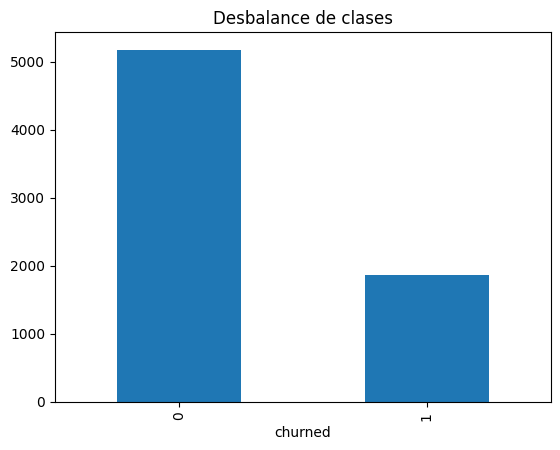

In [23]:
unbalanced.plot(
    kind='bar',
    title = 'Desbalance de clases',
)
plt.show()

Se puede observar un claro desbalance de clases. Para lidear con este problema, se puede aprovechar el potencial de algoritmos como LightGBM y CatBoost los cuales incluyen herrmanentas para tratar con este problema

Ahora veremos la distribución de los valores "total_charges" y "monthly_charges" 

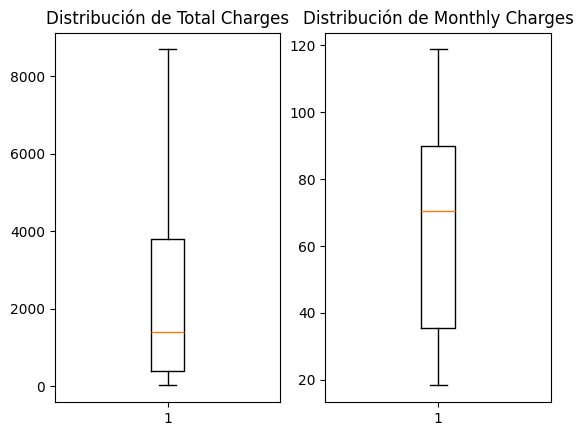

In [24]:
fig, ax = plt.subplots(1,2)

ax[0].boxplot(contract['total_charges'])
ax[0].set_title('Distribución de Total Charges')

ax[1].boxplot(contract['monthly_charges'])
ax[1].set_title('Distribución de Monthly Charges')
plt.show()

Como se puede observar en los gráficos, no existen valores atípicos dentro de estas columnas

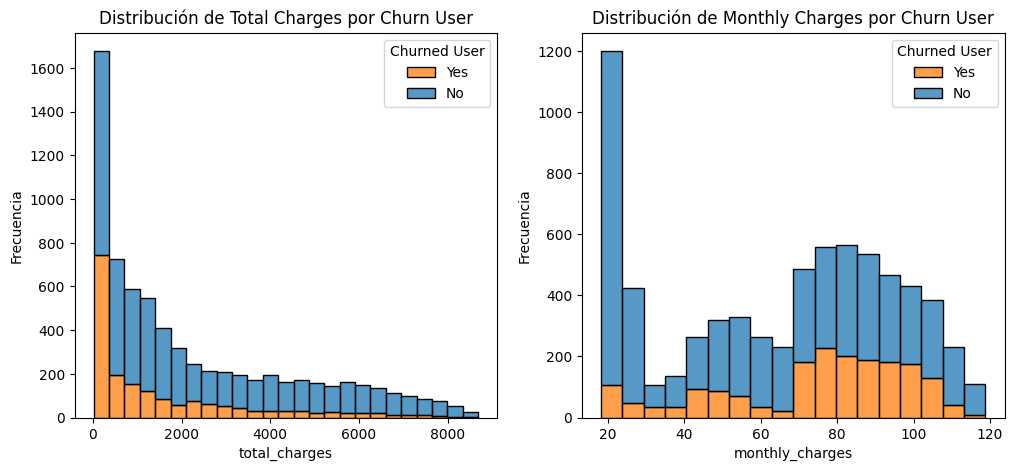

In [25]:
# Distribución de total charges y montly charges por churn user
fig, ax = plt.subplots(1,2, figsize=(12, 5))

sns.histplot(data=contract, x='total_charges', hue='churned', multiple='stack', ax=ax[0])
ax[0].set_title('Distribución de Total Charges por Churn User')
ax[0].set_ylabel('Frecuencia')
ax[0].legend(title = 'Churned User', labels = ['Yes', 'No'])

sns.histplot(data=contract, x='monthly_charges', hue='churned', multiple='stack', ax=ax[1])
ax[1].set_title('Distribución de Monthly Charges por Churn User')
ax[1].set_ylabel('Frecuencia')
ax[1].legend(title = 'Churned User', labels = ['Yes', 'No'])
plt.show()

Como se puede observar los usuarios que han cancelado su suscripción tienden a pagar cargos mensuales más altos en comparación con los que han mantenido el servicio. Además, aunque ambos grupos presentan una alta concentración de cargos totales bajos, los usuarios que continúan con el servicio son más numerosos en esta categoría. Esto sugiere que los costos más elevados pueden influir en la decisión de cancelar la suscripción. 

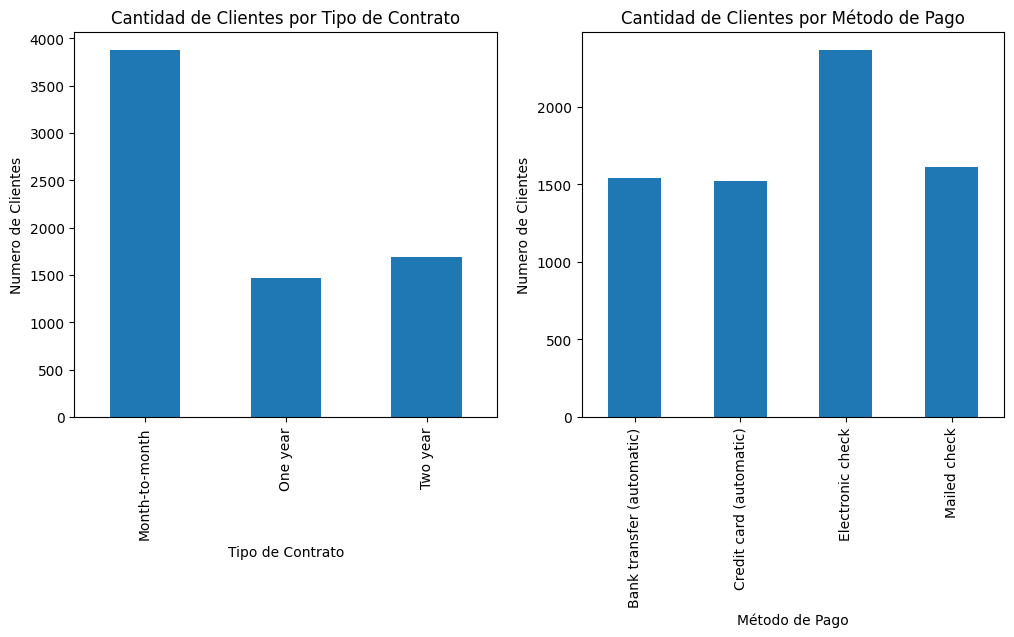

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
contract.groupby(['type'])['customer_id'].count().plot(
    kind = 'bar', 
    title = 'Cantidad de Clientes por Tipo de Contrato', 
    xlabel = 'Tipo de Contrato',
    ylabel = 'Numero de Clientes'
)

plt.subplot(1,2,2)
contract.groupby(['payment_method'])['customer_id'].count().plot(
    kind = 'bar', 
    title = 'Cantidad de Clientes por Método de Pago',
    xlabel = 'Método de Pago',
    ylabel = 'Numero de Clientes'
)
plt.show()

Como se puede observar la mayoria de los usuarios prefieren el contrato de mes a mes, lo que sugiere que tienen una preferencia por la flexibilidad en la suscripción. 

En cuanto al metodo de pago, el cheque electrónico es el más utilizado, esto indica que muchos clientes prefieren opciones menos automatizadas para hacer el cobro. 

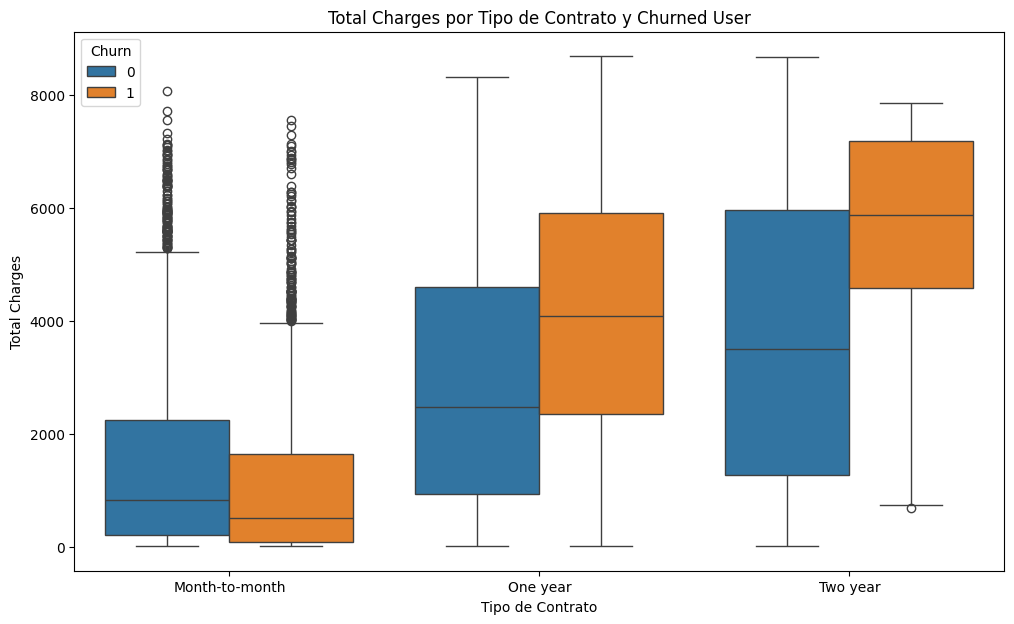

In [27]:
plt.figure(figsize = (12,7))
sns.boxplot(x = 'type', y = 'total_charges', data = contract, hue = 'churned')
plt.title('Total Charges por Tipo de Contrato y Churned User')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Total Charges')
plt.legend(title = 'Churn')
plt.show()

Los clientes con contratos más largos tienden a acumular cargos totales más altos, mientras que los de contratos mes a mes muestran una mayor variabilidad, con costos más bajos para quienes cancelaron el servicio. Esto sugiere que la permanencia influye en el monto acumulado. 

In [28]:
# Revisión de datos atipicos en total charges en contratos mensuales
mtm_outliers = contract.query('type == "Month-to-month" & total_charges > 5000')
mtm_outliers.sample(20) 

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churned
1357,7130-YXBRO,2016-02-01,No,Month-to-month,Yes,Bank transfer (automatic),111.45,5315.10,0
1950,9614-RMGHA,2014-07-01,2019-12-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),91.85,5940.85,1
6037,7537-CBQUZ,2014-11-01,No,Month-to-month,Yes,Bank transfer (automatic),109.40,7031.45,0
1904,3143-ILDAL,2015-05-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,94.45,5124.60,1
6819,3005-NFMTA,2015-04-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,98.80,5617.75,1
2763,2250-IVBWA,2014-10-01,No,Month-to-month,No,Electronic check,81.05,5135.35,0
6351,1842-EZJMK,2015-11-01,2020-01-01 00:00:00,Month-to-month,No,Electronic check,103.70,5071.05,1
243,9058-HRZSV,2014-09-01,No,Month-to-month,No,Electronic check,94.40,6126.15,0
6871,4070-OKWVH,2015-10-01,No,Month-to-month,No,Bank transfer (automatic),94.60,5025.80,0
3783,1469-LBJQJ,2014-08-01,No,Month-to-month,Yes,Electronic check,105.20,6936.85,0


Como se puede observar los costos totales son altos debido a que los clientes llevan varios años utilizando los servicios de la compañia. 

## Unión de Tablas 

In [29]:
from functools import reduce 

df = pd.merge(internet, contract, on='customer_id', how='left')
df = pd.merge(df, phone, on='customer_id', how='left')
df = pd.merge(df, personal, on='customer_id', how='left')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        5517 non-null   object        
 1   internet_service   5517 non-null   object        
 2   online_security    5517 non-null   object        
 3   online_backup      5517 non-null   object        
 4   device_protection  5517 non-null   object        
 5   tech_support       5517 non-null   object        
 6   streaming_tv       5517 non-null   object        
 7   streaming_movies   5517 non-null   object        
 8   begin_date         5517 non-null   datetime64[ns]
 9   end_date           5517 non-null   object        
 10  type               5517 non-null   object        
 11  paperless_billing  5517 non-null   object        
 12  payment_method     5517 non-null   object        
 13  monthly_charges    5517 non-null   float64       
 14  total_ch

In [30]:
df.isna().sum()

customer_id            0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
churned                0
multiple_lines       682
gender                 0
senior_citizen         0
partner                0
dependents             0
dtype: int64

In [31]:
nan_val = df[df.isna().any(axis=1)]
nan_val

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,...,paperless_billing,payment_method,monthly_charges,total_charges,churned,multiple_lines,gender,senior_citizen,partner,dependents
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,2020-01-01,No,...,Yes,Electronic check,29.85,29.85,0,NaN,Female,0,Yes,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,...,No,Bank transfer (automatic),42.30,1840.75,0,NaN,Male,0,No,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No,2019-04-01,No,...,No,Mailed check,29.75,301.90,0,NaN,Female,0,No,No
18,8779-QRDMV,DSL,No,No,Yes,No,No,Yes,2019-11-01,2019-12-01 00:00:00,...,Yes,Electronic check,39.65,39.65,1,NaN,Male,1,No,No
23,8665-UTDHZ,DSL,No,Yes,No,No,No,No,2019-11-01,2019-12-01 00:00:00,...,No,Electronic check,30.20,30.20,1,NaN,Male,0,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,4501-VCPFK,DSL,No,No,Yes,Yes,No,No,2017-12-01,No,...,No,Electronic check,35.75,1022.50,0,NaN,Male,0,No,No
5486,2274-XUATA,DSL,Yes,Yes,Yes,Yes,Yes,Yes,2014-02-01,No,...,Yes,Bank transfer (automatic),63.10,4685.55,0,NaN,Male,1,Yes,No
5505,2235-DWLJU,DSL,No,No,No,No,Yes,Yes,2019-08-01,No,...,Yes,Electronic check,44.40,263.05,0,NaN,Female,1,No,No
5511,7750-EYXWZ,DSL,No,Yes,Yes,Yes,Yes,Yes,2019-02-01,No,...,No,Electronic check,60.65,743.30,0,NaN,Female,0,No,No


In [32]:
# Imputar valores nulos con "unknown" para no perder información 

df.multiple_lines.fillna('unknown', inplace=True) 

C:\Users\lloyd\AppData\Local\Temp\ipykernel_19792\457028607.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.multiple_lines.fillna('unknown', inplace=True)


In [33]:
# Se crean 3 nuevas columnas para la fecha con dia, mes y año 

df['day'] = df['begin_date'].dt.day.astype('int')
df['month'] = df['begin_date'].dt.month.astype('int')
df['year'] = df['begin_date'].dt.year.astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        5517 non-null   object        
 1   internet_service   5517 non-null   object        
 2   online_security    5517 non-null   object        
 3   online_backup      5517 non-null   object        
 4   device_protection  5517 non-null   object        
 5   tech_support       5517 non-null   object        
 6   streaming_tv       5517 non-null   object        
 7   streaming_movies   5517 non-null   object        
 8   begin_date         5517 non-null   datetime64[ns]
 9   end_date           5517 non-null   object        
 10  type               5517 non-null   object        
 11  paperless_billing  5517 non-null   object        
 12  payment_method     5517 non-null   object        
 13  monthly_charges    5517 non-null   float64       
 14  total_ch

In [34]:
df

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,...,total_charges,churned,multiple_lines,gender,senior_citizen,partner,dependents,day,month,year
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,2020-01-01,No,...,29.85,0,unknown,Female,0,Yes,No,1,1,2020
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,...,1889.50,0,No,Male,0,No,No,1,4,2017
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,...,108.15,1,No,Male,0,No,No,1,10,2019
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,...,1840.75,0,unknown,Male,0,No,No,1,5,2016
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,...,151.65,1,No,Female,0,No,No,1,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes,2018-02-01,No,...,1990.50,0,Yes,Male,0,Yes,Yes,1,2,2018
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes,2014-02-01,No,...,7362.90,0,Yes,Female,0,Yes,Yes,1,2,2014
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No,2019-03-01,No,...,346.45,0,unknown,Female,0,Yes,Yes,1,3,2019
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No,2019-07-01,2019-11-01 00:00:00,...,306.60,1,Yes,Male,1,Yes,No,1,7,2019


## Escalamiento de datos

In [35]:
from sklearn.preprocessing import StandardScaler 

# Escalamiento de variables numéricas 
numeric = ['total_charges', 'monthly_charges', 'day', 'month', 'year']

scaler = StandardScaler() 
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])


## Etiquetado de Datos 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['churned', 'customer_id', 'begin_date', 'end_date']),
    df['churned'],
    test_size = 0.2,
    random_state = 123
    )

### Target Encoding 

In [37]:
# Se seleccionan las columnas categóricas 
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

churned_means_dict = {
    col: df.groupby(col)['churned'].mean().to_dict()
    for col in cat_cols
}

# Se crea un target encoder para las columnas categóricas 
enc_X_train = X_train.copy()
enc_X_test = X_test.copy()

for col in cat_cols:
    enc_X_train[f'{col}_target_enc'] = enc_X_train[col].map(churned_means_dict[col])
    enc_X_test[f'{col}_target_enc'] = enc_X_test[col].map(churned_means_dict[col])

# Eliminar columnas categóricas originales   
enc_X_train.drop(columns=cat_cols, inplace=True)
enc_X_test.drop(columns=cat_cols, inplace=True)

enc_X_train.head() 

,monthly_charges,total_charges,senior_citizen,day,month,year,internet_service_target_enc,online_security_target_enc,online_backup_target_enc,device_protection_target_enc,tech_support_target_enc,streaming_tv_target_enc,streaming_movies_target_enc,type_target_enc,paperless_billing_target_enc,payment_method_target_enc,multiple_lines_target_enc,gender_target_enc,partner_target_enc,dependents_target_enc
1881,0.647993,0.697508,1,0.0,-1.271577,-0.418411,0.418928,0.417667,0.399288,0.225021,0.416355,0.335231,0.299414,0.464339,0.364564,0.187238,0.319513,0.314481,0.240240,0.36
1430,-0.061318,-1.126578,0,0.0,-1.554406,1.624848,0.189591,0.417667,0.399288,0.225021,0.151663,0.300702,0.299414,0.464339,0.364564,0.470798,0.338169,0.314481,0.391167,0.36
2829,-1.222216,0.006435,1,0.0,0.142568,-0.929225,0.189591,0.417667,0.399288,0.225021,0.416355,0.300702,0.299414,0.141569,0.364564,0.198020,0.249267,0.314481,0.391167,0.36
4124,0.568167,-0.913348,0,0.0,-0.140261,1.114033,0.418928,0.417667,0.399288,0.391276,0.416355,0.300702,0.299414,0.464339,0.222098,0.470798,0.338169,0.322145,0.391167,0.36
2254,1.190810,1.857190,1,0.0,-0.988748,-1.440040,0.418928,0.417667,0.215315,0.225021,0.416355,0.300702,0.299414,0.464339,0.364564,0.470798,0.319513,0.314481,0.240240,0.36


In [38]:
enc_X_test.head()

,monthly_charges,total_charges,senior_citizen,day,month,year,internet_service_target_enc,online_security_target_enc,online_backup_target_enc,device_protection_target_enc,tech_support_target_enc,streaming_tv_target_enc,streaming_movies_target_enc,type_target_enc,paperless_billing_target_enc,payment_method_target_enc,multiple_lines_target_enc,gender_target_enc,partner_target_enc,dependents_target_enc
2730,-0.268866,0.221745,0,0.0,-0.140261,-0.418411,0.189591,0.417667,0.215315,0.225021,0.151663,0.300702,0.336804,0.141569,0.364564,0.470798,0.338169,0.314481,0.240240,0.36
4071,0.716416,-0.472918,1,0.0,0.708226,0.603219,0.418928,0.417667,0.399288,0.391276,0.416355,0.300702,0.299414,0.464339,0.364564,0.470798,0.319513,0.322145,0.240240,0.36
137,0.232898,-0.656781,0,0.0,1.556713,0.603219,0.189591,0.417667,0.215315,0.225021,0.151663,0.300702,0.299414,0.040681,0.222098,0.272101,0.338169,0.314481,0.240240,0.36
724,0.775715,-0.468267,0,0.0,-0.140261,0.603219,0.418928,0.146112,0.399288,0.391276,0.416355,0.300702,0.299414,0.464339,0.222098,0.470798,0.338169,0.314481,0.391167,0.36
3821,0.378866,0.400130,1,0.0,-0.140261,-0.418411,0.418928,0.146112,0.215315,0.391276,0.151663,0.335231,0.336804,0.464339,0.364564,0.470798,0.338169,0.322145,0.240240,0.36


### Ordinal Encoding

In [39]:
ord_X_train = X_train.copy()
ord_X_test = X_test.copy()

for col in cat_cols: 
    encoder = OrdinalEncoder()
    encoder.fit(np.array(ord_X_train[col]).reshape(-1,1))

    ord_X_train[col] = encoder.transform(np.array(ord_X_train[col]).reshape(-1,1))
    ord_X_test[col] = encoder.transform(np.array(ord_X_test[col]).reshape(-1,1))

ord_X_train.head()


,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,gender,senior_citizen,partner,dependents,day,month,year
1881,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.647993,0.697508,1.0,1.0,1,1.0,0.0,0.0,-1.271577,-0.418411
1430,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,-0.061318,-1.126578,0.0,1.0,0,0.0,0.0,0.0,-1.554406,1.624848
2829,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,-1.222216,0.006435,2.0,1.0,1,0.0,0.0,0.0,0.142568,-0.929225
4124,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.568167,-0.913348,0.0,0.0,0,0.0,0.0,0.0,-0.140261,1.114033
2254,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.190810,1.857190,1.0,1.0,1,1.0,0.0,0.0,-0.988748,-1.440040


In [40]:
ord_X_test.head() 

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,gender,senior_citizen,partner,dependents,day,month,year
2730,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,-0.268866,0.221745,0.0,1.0,0,1.0,0.0,0.0,-0.140261,-0.418411
4071,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.716416,-0.472918,1.0,0.0,1,1.0,0.0,0.0,0.708226,0.603219
137,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0,0.232898,-0.656781,0.0,1.0,0,1.0,0.0,0.0,1.556713,0.603219
724,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.775715,-0.468267,0.0,1.0,0,0.0,0.0,0.0,-0.140261,0.603219
3821,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.378866,0.400130,0.0,0.0,1,1.0,0.0,0.0,-0.140261,-0.418411


## Entrenamiento de Modelos

### Función para Evaluación del Modelo

In [41]:
from sklearn.metrics import accuracy_score, f1_score
def eval_model(model, X_test, y_test):
    """
    Evalua el modelo y retorna el AUC-ROC, accuracy y F1-score.
    """
    if hasattr(model, 'best_estimator_'): 
        best_model = model.best_estimator_ 
    else: 
        best_model = model
    
    # Predicciones y metricas 
    pred = best_model.predict(X_test) 
    prob = best_model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    roc_auc = roc_auc_score(y_test, prob)
    print(f'ROC AUC: {roc_auc:.4f}\nAccuracy: {acc:.4f}\nF1-Score: {f1:.4f}\nBest Model: {best_model}')
    return {'ROC-AUC':roc_auc, 'Accuracy':acc, 'F1':f1, 'Best Model':best_model}

### LGBM Classifier

In [42]:
lgb_classifier = LGBMClassifier(
    max_depth = 5, 
    random_state = 123,
    n_jobs = -1,
    verbose = -1
)

param_grid = {
    'colsample_bytree' : [0.8, 0.9, 1.0],
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'num_leaves' : [5, 10, 20],
    'n_estimators' : [50, 100, 200],
    'scale_pos_weight' : [1, 10, 20, 30, 40]
}

# Grid Search para encontrar los mejores hiperparpámetros 

grid_search = GridSearchCV(
    estimator = lgb_classifier,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3, 
    n_jobs = -1
)

grid_search_targ = GridSearchCV(
    estimator = lgb_classifier,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 3, 
    n_jobs = -1
)

In [43]:
grid_search.fit(ord_X_train, y_train)
grid_search_targ.fit(enc_X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(max_depth=5, n_jobs=-1, random_state=123,
                                      verbose=-1),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [5, 10, 20],
                         'scale_pos_weight': [1, 10, 20, 30, 40]},
             scoring='roc_auc')

In [44]:
print('Target Encoding:\n')
print(f'Mejores parámetros: {grid_search_targ.best_params_}')
print(f'Mejor score ROC AUC: {grid_search_targ.best_score_}')

print('\nOrdinal Encoding:\n')
print(f'Mejores parámetros: {grid_search.best_params_}')
print(f'Mejor score ROC AUC: {grid_search.best_score_}\n')

Target Encoding:

Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 20, 'scale_pos_weight': 1}
Mejor score ROC AUC: 0.8914106048259552

Ordinal Encoding:

Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 20, 'scale_pos_weight': 10}
Mejor score ROC AUC: 0.8929647969529168



In [45]:
lgbm_pred_proba_targ = grid_search_targ.predict_proba(enc_X_test)[:,1]
lgbm_pred_proba = grid_search.predict_proba(ord_X_test)[:,1]

print('Target Encoding:\n')
result_lgbm_targ = eval_model(grid_search_targ, enc_X_test, y_test)

print('\nOrdinal Encoding:\n')
result_lgbm_ord = eval_model(grid_search, ord_X_test, y_test)

Target Encoding:

ROC AUC: 0.9096
Accuracy: 0.8650
F1-Score: 0.7504
Best Model: LGBMClassifier(max_depth=5, n_estimators=200, n_jobs=-1, num_leaves=20,
               random_state=123, scale_pos_weight=1, verbose=-1)

Ordinal Encoding:

ROC AUC: 0.9047
Accuracy: 0.7237
F1-Score: 0.6652
Best Model: LGBMClassifier(max_depth=5, n_estimators=200, n_jobs=-1, num_leaves=20,
               random_state=123, scale_pos_weight=10, verbose=-1)


Se puede observar como el modelo tiene lihgeramente un mejor rendimiento con target encoding

In [46]:
result_df = pd.DataFrame([result_lgbm_targ], index=['LGBM Classifier (Target Enc)'])
result_df = pd.concat([result_df, pd.DataFrame([result_lgbm_ord], index = ['LGBM Classifier (Ordinal Enc)'])])

In [47]:
# Guardamos los mejores hiperparámetros para el mejor modelo LGBM
tuned_LGBM_model = grid_search_targ.best_estimator_

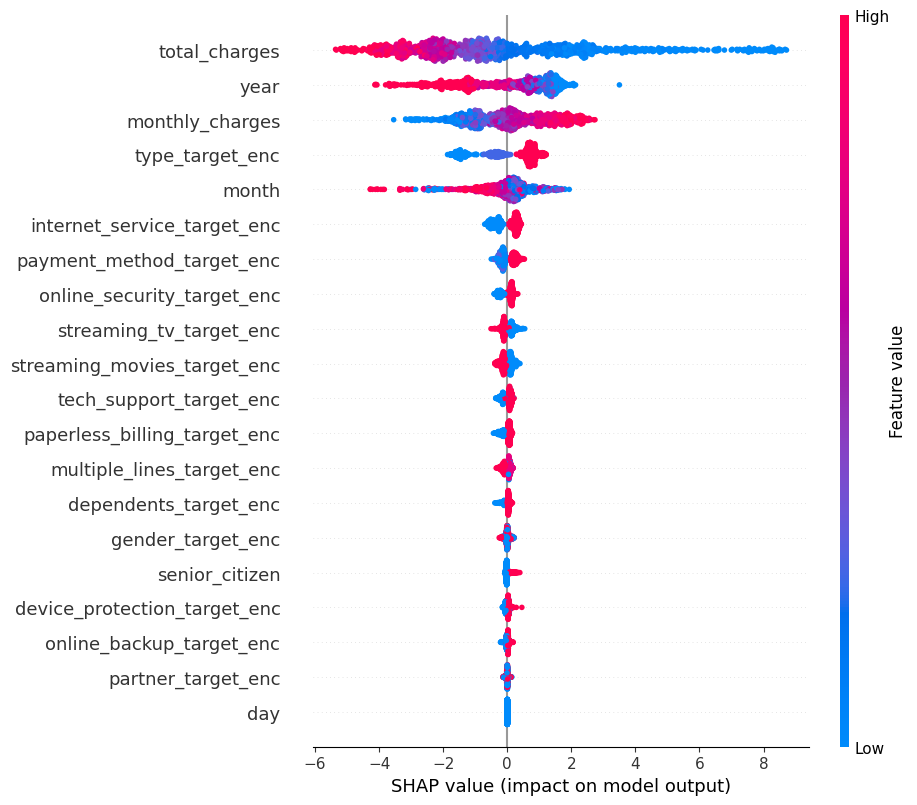

In [48]:
# Impacto de las características en el modelo
exp = shap.Explainer(tuned_LGBM_model)
shap_values = exp(enc_X_test)

shap.plots.beeswarm(
    shap_values,
    max_display=23,
    )

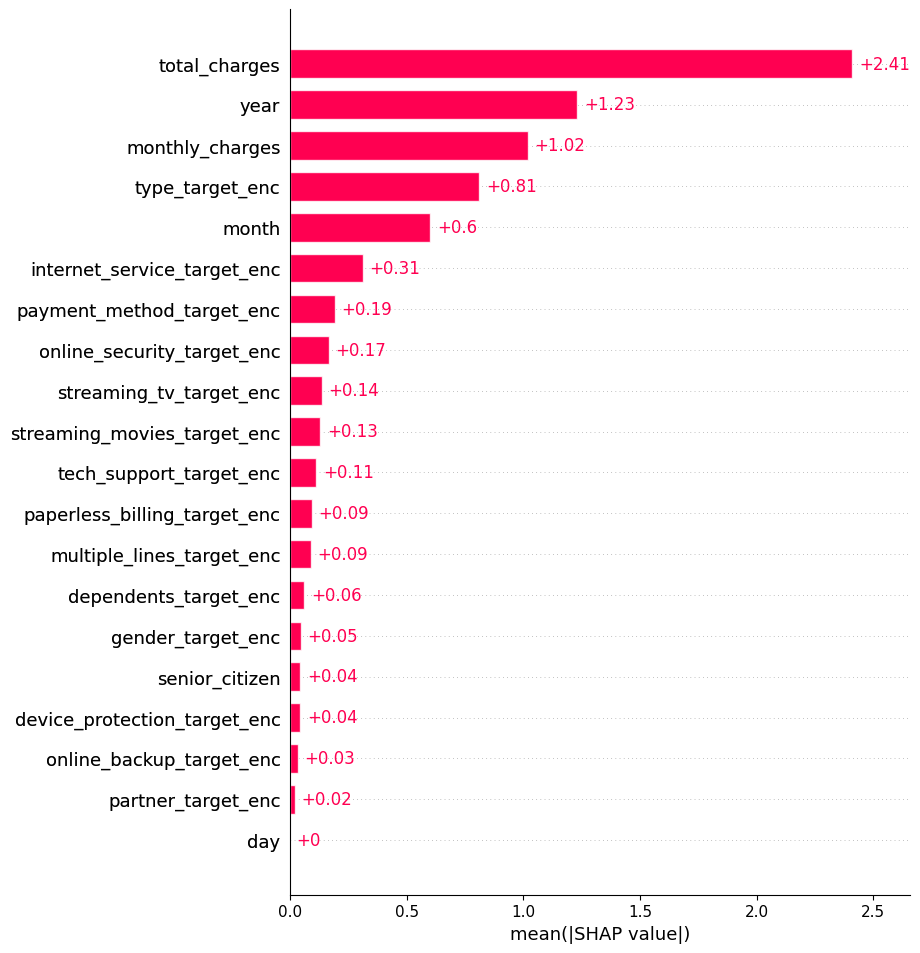

In [49]:
shap.plots.bar(
    shap_values,
    max_display = 23
)

Se puede observar como 'senior_citizen', 'online_backup', 'gender', 'partner' y day son las variables que menos aportan a la predicción del modelo. 

Se tratara de hacer un modelo sin estas caracteristicas

In [50]:
tuned_LGBM_model.fit(
    enc_X_train.drop(columns=['senior_citizen', 'online_backup_target_enc', 'gender_target_enc', 'partner_target_enc', 'day']), y_train
    )

result_lgbm_less_val = eval_model(tuned_LGBM_model, enc_X_test.drop(columns=['senior_citizen', 'online_backup_target_enc', 'gender_target_enc', 'partner_target_enc', 'day']), y_test) 

ROC AUC: 0.9089
Accuracy: 0.8641
F1-Score: 0.7517
Best Model: LGBMClassifier(max_depth=5, n_estimators=200, n_jobs=-1, num_leaves=20,
               random_state=123, scale_pos_weight=1, verbose=-1)


In [51]:
result_df = pd.concat([result_df, pd.DataFrame([result_lgbm_less_val], index=['LGBM Classifier (less features / target enc)'])])

Se puede observar como se obtuvo un menor rendimiento al utilizar menos caracteristicas de un valor ROC-AUC de al rededor de 0.9089 a comparación de utilizar target encoding donde conseguimos un valor ROC-AUC de 0.9096.

En este caso se procede a utilizar el valor con target encoding sin remover variables. 

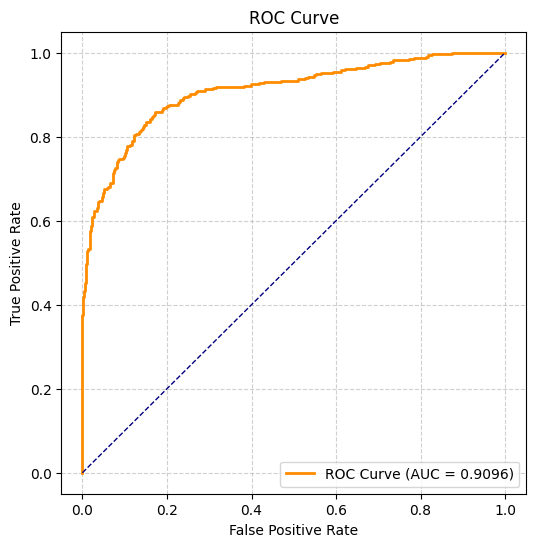

In [52]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, lgbm_pred_proba_targ)
roc_auc = auc(fpr, tpr)

# Plot with styling
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## CatBoost Classifier 

In [53]:
# Inicialización del modelo CatBoost
catboost = CatBoostClassifier(verbose=0)

# Hiperparámetros para el modelo CatBoost
param_grid_cat = {
    'learning_rate': [0.001, 0.003, 0.008, 0.1],
    'depth': [3, 5, 7, 10],
    'n_estimators': [25, 50, 100], 
    'scale_pos_weight': [1, 5, 10, 20]
}

# Grid Search para encontrar los mejores hiperparámetros 
grid_search_cat = GridSearchCV(
    estimator = catboost, 
    param_grid = param_grid_cat,
    scoring = 'roc_auc',
    cv = 5, 
    verbose = 0, 
    n_jobs = -1
)

In [54]:
# Entrenamiento del modelo CatBoost con Grid Search
grid_search_cat.fit(enc_X_train, y_train) 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021ED3393E30>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7, 10],
                         'learning_rate': [0.001, 0.003, 0.008, 0.1],
                         'n_estimators': [25, 50, 100],
                         'scale_pos_weight': [1, 5, 10, 20]},
             scoring='roc_auc')

In [55]:
result_catboost = eval_model(grid_search_cat, enc_X_test, y_test)

ROC AUC: 0.8952
Accuracy: 0.8542
F1-Score: 0.7339
Best Model: <catboost.core.CatBoostClassifier object at 0x0000021ED33F2690>


In [56]:
result_df = pd.concat([result_df, pd.DataFrame([result_catboost], index=['CatBoost'])])

### Random Forest

#### Balanceo de Datos 

In [57]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='auto', random_state=123)
X_train_ros, y_train_ros = ros.fit_resample(enc_X_train, y_train) 

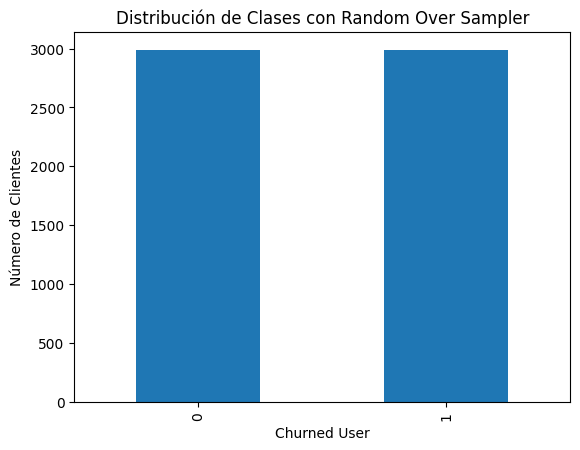

In [58]:
y_train_ros.value_counts().plot(
    kind='bar', 
    title = 'Distribución de Clases con Random Over Sampler',
    xlabel = 'Churned User',
    ylabel = 'Número de Clientes'
)

plt.show() 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

param_grid_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [10, 20, 30, 50],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

# Inicialización del modelo
model_rf = RandomForestClassifier(random_state=123, n_jobs=-1) 

# Grid Search para encontrar los mejores hiperparámetros
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv = 3,
    n_jobs=-1
)

# Selección de variables
select_rf = SelectFromModel(
    estimator=model_rf,
    threshold='mean'
)

select_rf.fit(X_train_ros, y_train_ros)
select_rf_col = X_train_ros.columns[select_rf.get_support()].tolist()

print(f'Caracteristicas seleccionadas para RF: {select_rf_col}')

# Entrenamiento del modelo 
grid_search_rf.fit(X_train_ros[select_rf_col], y_train_ros)


Caracteristicas seleccionadas para RF: ['monthly_charges', 'total_charges', 'month', 'year', 'type_target_enc', 'payment_method_target_enc']


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [5, 10, 15, 20],
                         'n_estimators': [10, 20, 30, 50]},
             scoring='roc_auc')

In [60]:
result_rf = eval_model(grid_search_rf, enc_X_test[select_rf_col], y_test) 

ROC AUC: 0.8812
Accuracy: 0.8442
F1-Score: 0.7304
Best Model: RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_split=5,
                       n_estimators=50, n_jobs=-1, random_state=123)


In [61]:
result_df = pd.concat([result_df, pd.DataFrame([result_rf], index=['Random Forest'])])

### Logistic Regression

In [62]:
model_lr = LogisticRegression(random_state=123)

# Selección de caracteristicas 
select_lr = SelectFromModel(estimator=model_lr, threshold = 'mean')
select_lr.fit(X_train_ros, y_train_ros)
select_lr_col = X_train_ros.columns[select_lr.get_support()].tolist()
print('Características seleccionadas:',select_lr_col)

model_lr.fit(X_train_ros[select_lr_col], y_train_ros)

Características seleccionadas: ['total_charges', 'internet_service_target_enc', 'online_security_target_enc', 'online_backup_target_enc', 'device_protection_target_enc', 'tech_support_target_enc', 'streaming_movies_target_enc', 'type_target_enc', 'paperless_billing_target_enc', 'payment_method_target_enc', 'multiple_lines_target_enc']


LogisticRegression(random_state=123)

In [63]:
result_lr = eval_model(model_lr, enc_X_test[select_lr_col], y_test)

ROC AUC: 0.8215
Accuracy: 0.7210
F1-Score: 0.6410
Best Model: LogisticRegression(random_state=123)


In [64]:
result_df = pd.concat([result_df, pd.DataFrame([result_lr], index=['Logistic Regression'])])

In [65]:
result_df.sort_values(by='ROC-AUC', ascending=False)
result_df.drop(columns=['Best Model'], inplace = True)

In [66]:
result_df

,ROC-AUC,Accuracy,F1
LGBM Classifier (Target Enc),0.909619,0.865036,0.750419
LGBM Classifier (Ordinal Enc),0.904746,0.723732,0.665203
LGBM Classifier (less features / target enc),0.908909,0.864130,0.751656
CatBoost,0.895167,0.854167,0.733884
Random Forest,0.881176,0.844203,0.730408
Logistic Regression,0.821509,0.721014,0.641026


## Conclusión 

El análisis realizado sobre la tasa de cancelación de clientes de Interconnect ha permitido identificar patrones claves que influyen en la retención y abandono de usuarios. Mediante el uso de datos contractuales, personales y de servicios, se ha desarrollado un modelo predictivo capaz de anticipar cuándo un cliente tiene una alta probabilidad de cancelar su servicio.

Las métricas de rendimiento del modelo, incluyendo ROC'AUC, Accuracy y F1 indican que el LGBM Classifier ha sido la mejor opción para este caso. LGBM Classifier utilizando target encoding para las características alcanzo una puntuación ROC-AUC de 0.9096, lo que indica que tiene una mejor capacidad para distinguir entre clientes que se quedan y aquellos que cancelan el servicio. Adémas, el modelo obtuvo una accuracy de 0.8650 demostrando una sólida capacidad para hacer predicciones corectas y un F1-score de 0.7504 lo que confirma su buen desempeño en situaciones de datos desbalanceados. 